Общее количество записей: 191638
Записи с обновлениями (created_at != updated_at): 189667

Количество записей с обновлениями задним числом: 72060
Статистика по дням между датой расхода и обновлением:
count    72060.000000
mean         1.832043
std          8.579039
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        293.000000
Name: days_between_date_and_update, dtype: float64

Рекомендуемая глубина обновления (в днях) по персентилям:
90% записей обновляются в течение 1 дней
95% записей обновляются в течение 3 дней
99% записей обновляются в течение 10 дней
99.5% записей обновляются в течение 32 дней
99.9% записей обновляются в течение 118 дней

Рекомендуемая оптимальная глубина обновления: 3 дней

Возможные конверсионные записи (высокая стоимость при малом количестве кликов и показов):
Количество: 11502

Статистика по возможным конверсионным записям:
Среднее CPC: 409.9172317857764
Среднее CPM: 62202.56057681191
Среднее количество кликов: 1

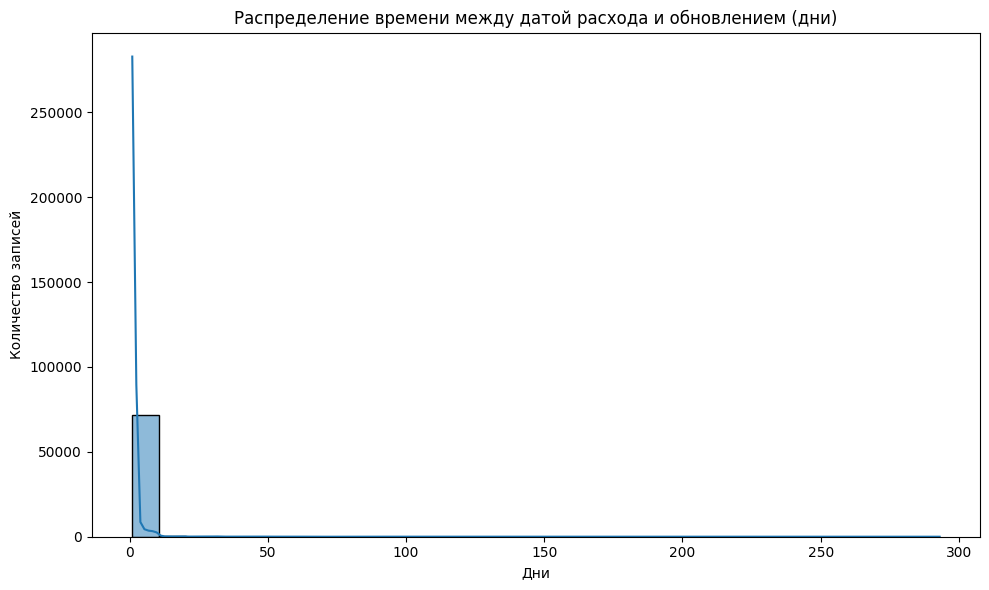

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

# Загрузка данных
df = pd.read_csv('Result_48.csv')

# Преобразование строковых дат в datetime
df['date'] = pd.to_datetime(df['date'])
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])

# Нормализация cost (деление на миллион)
df['cost_rub'] = df['cost'] / 1000000

# Расчет времени между date и updated_at
df['days_between_date_and_update'] = (df['updated_at'] - pd.to_datetime(df['date'])).dt.days

# Расчет времени между created_at и updated_at в часах
df['hours_between_create_and_update'] = (df['updated_at'] - df['created_at']).dt.total_seconds() / 3600

# Создание признака для выявления возможных конверсионных записей
# Относительно высокая стоимость при малом количестве кликов и показов
df['cpc'] = df['cost_rub'] / df['clicks'].where(df['clicks'] > 0, 1)
df['cpm'] = (df['cost_rub'] / df['shows'].where(df['shows'] > 0, 1)) * 1000
df['possible_conversion'] = ((df['cpc'] > df['cpc'].quantile(0.75)) & 
                           (df['clicks'] < df['clicks'].quantile(0.25)) & 
                           (df['shows'] < df['shows'].quantile(0.25)))

# 1. Анализ обновлений расходов
print("Общее количество записей:", len(df))
print("Записи с обновлениями (created_at != updated_at):", 
      len(df[df['created_at'] != df['updated_at']]))

# 2. Распределение времени между датой расхода и последним обновлением
update_delays = df[df['days_between_date_and_update'] > 0]
print("\nКоличество записей с обновлениями задним числом:", len(update_delays))

if len(update_delays) > 0:
    print("Статистика по дням между датой расхода и обновлением:")
    print(update_delays['days_between_date_and_update'].describe())
    
    # Гистограмма распределения времени обновления
    plt.figure(figsize=(10, 6))
    sns.histplot(update_delays['days_between_date_and_update'], bins=30, kde=True)
    plt.title('Распределение времени между датой расхода и обновлением (дни)')
    plt.xlabel('Дни')
    plt.ylabel('Количество записей')
    plt.tight_layout()
    plt.savefig('update_delay_distribution.png')
    
    # 3. Вычисление оптимальной глубины обновления
    percentiles = [90, 95, 99, 99.5, 99.9]
    depths = {}
    for p in percentiles:
        depths[p] = np.ceil(np.percentile(update_delays['days_between_date_and_update'], p))
    
    print("\nРекомендуемая глубина обновления (в днях) по персентилям:")
    for p, depth in depths.items():
        print(f"{p}% записей обновляются в течение {int(depth)} дней")
    
    optimal_depth = int(depths[95])  # Используем 95-й персентиль как оптимальную глубину
    print(f"\nРекомендуемая оптимальная глубина обновления: {optimal_depth} дней")
else:
    print("В данных нет записей с обновлениями задним числом")

# 4. Анализ возможных конверсионных записей
print("\nВозможные конверсионные записи (высокая стоимость при малом количестве кликов и показов):")
conv_records = df[df['possible_conversion']]
print(f"Количество: {len(conv_records)}")

if len(conv_records) > 0:
    print("\nСтатистика по возможным конверсионным записям:")
    print("Среднее CPC:", conv_records['cpc'].mean())
    print("Среднее CPM:", conv_records['cpm'].mean())
    print("Среднее количество кликов:", conv_records['clicks'].mean())
    print("Среднее количество показов:", conv_records['shows'].mean())
    
    # Анализ времени обновления для возможных конверсионных записей
    if len(conv_records[conv_records['days_between_date_and_update'] > 0]) > 0:
        print("\nСтатистика по времени обновления для возможных конверсионных записей:")
        print(conv_records[conv_records['days_between_date_and_update'] > 0]['days_between_date_and_update'].describe())
        
        # Рекомендуемая глубина для конверсионных записей
        conv_optimal_depth = int(np.ceil(np.percentile(
            conv_records[conv_records['days_between_date_and_update'] > 0]['days_between_date_and_update'], 95)))
        print(f"\nРекомендуемая глубина обновления для конверсионных записей: {conv_optimal_depth} дней")

# 5. Сводный отчет
print("\n=== СВОДНЫЙ ОТЧЕТ ===")
print("Может ли Яндекс обновлять расходы задним числом?")
if len(update_delays) > 0:
    print("ДА, в данных обнаружены обновления задним числом.")
    print(f"Максимальная обнаруженная глубина обновления: {update_delays['days_between_date_and_update'].max()} дней")
    print(f"Рекомендуемая глубина обновления данных: {optimal_depth} дней")
    
    if len(conv_records) > 0 and len(conv_records[conv_records['days_between_date_and_update'] > 0]) > 0:
        print(f"Для возможных конверсионных записей: {conv_optimal_depth} дней")
else:
    print("НЕТ, в предоставленных данных не обнаружены обновления задним числом.")

Общее количество записей: 191246
Записи с обновлениями (created_at != updated_at): 189275

Количество записей с обновлениями задним числом: 71668
Статистика по дням между датой расхода и обновлением:
count    71668.000000
mean         1.342789
std          1.626811
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         29.000000
Name: days_between_date_and_update, dtype: float64

Рекомендуемая глубина обновления (в днях) по персентилям:
90% записей обновляются в течение 1 дней
95% записей обновляются в течение 3 дней
99% записей обновляются в течение 9 дней
99.5% записей обновляются в течение 10 дней
99.9% записей обновляются в течение 23 дней

Рекомендуемая оптимальная глубина обновления: 3 дней

Возможные конверсионные записи (высокая стоимость при малом количестве кликов и показов):
Количество: 11413

Статистика по возможным конверсионным записям:
Среднее CPC: 410.0258380793832
Среднее CPM: 62529.25451176094
Среднее количество кликов: 1.4

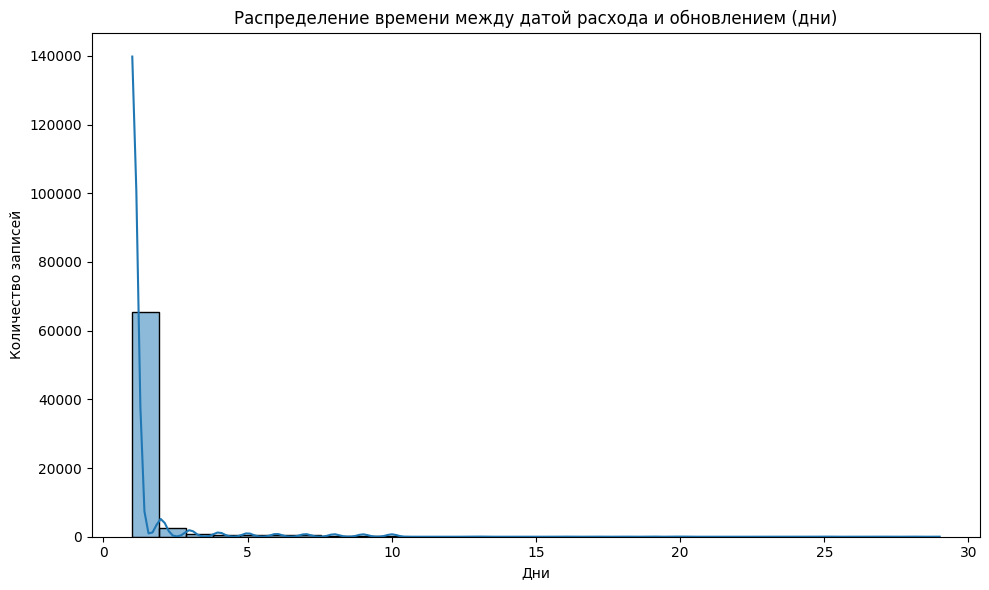

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

# Загрузка данных
df = pd.read_csv('Result_53.csv')

# Преобразование строковых дат в datetime
df['date'] = pd.to_datetime(df['date'])
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])

# Нормализация cost (деление на миллион)
df['cost_rub'] = df['cost'] / 1000000

# Расчет времени между date и updated_at
df['days_between_date_and_update'] = (df['updated_at'] - pd.to_datetime(df['date'])).dt.days

# Расчет времени между created_at и updated_at в часах
df['hours_between_create_and_update'] = (df['updated_at'] - df['created_at']).dt.total_seconds() / 3600

# Создание признака для выявления возможных конверсионных записей
# Относительно высокая стоимость при малом количестве кликов и показов
df['cpc'] = df['cost_rub'] / df['clicks'].where(df['clicks'] > 0, 1)
df['cpm'] = (df['cost_rub'] / df['shows'].where(df['shows'] > 0, 1)) * 1000
df['possible_conversion'] = ((df['cpc'] > df['cpc'].quantile(0.75)) & 
                           (df['clicks'] < df['clicks'].quantile(0.25)) & 
                           (df['shows'] < df['shows'].quantile(0.25)))

# 1. Анализ обновлений расходов
print("Общее количество записей:", len(df))
print("Записи с обновлениями (created_at != updated_at):", 
      len(df[df['created_at'] != df['updated_at']]))

# 2. Распределение времени между датой расхода и последним обновлением
update_delays = df[df['days_between_date_and_update'] > 0]
print("\nКоличество записей с обновлениями задним числом:", len(update_delays))

if len(update_delays) > 0:
    print("Статистика по дням между датой расхода и обновлением:")
    print(update_delays['days_between_date_and_update'].describe())
    
    # Гистограмма распределения времени обновления
    plt.figure(figsize=(10, 6))
    sns.histplot(update_delays['days_between_date_and_update'], bins=30, kde=True)
    plt.title('Распределение времени между датой расхода и обновлением (дни)')
    plt.xlabel('Дни')
    plt.ylabel('Количество записей')
    plt.tight_layout()
    plt.savefig('update_delay_distribution.png')
    
    # 3. Вычисление оптимальной глубины обновления
    percentiles = [90, 95, 99, 99.5, 99.9]
    depths = {}
    for p in percentiles:
        depths[p] = np.ceil(np.percentile(update_delays['days_between_date_and_update'], p))
    
    print("\nРекомендуемая глубина обновления (в днях) по персентилям:")
    for p, depth in depths.items():
        print(f"{p}% записей обновляются в течение {int(depth)} дней")
    
    optimal_depth = int(depths[95])  # Используем 95-й персентиль как оптимальную глубину
    print(f"\nРекомендуемая оптимальная глубина обновления: {optimal_depth} дней")
else:
    print("В данных нет записей с обновлениями задним числом")

# 4. Анализ возможных конверсионных записей
print("\nВозможные конверсионные записи (высокая стоимость при малом количестве кликов и показов):")
conv_records = df[df['possible_conversion']]
print(f"Количество: {len(conv_records)}")

if len(conv_records) > 0:
    print("\nСтатистика по возможным конверсионным записям:")
    print("Среднее CPC:", conv_records['cpc'].mean())
    print("Среднее CPM:", conv_records['cpm'].mean())
    print("Среднее количество кликов:", conv_records['clicks'].mean())
    print("Среднее количество показов:", conv_records['shows'].mean())
    
    # Анализ времени обновления для возможных конверсионных записей
    if len(conv_records[conv_records['days_between_date_and_update'] > 0]) > 0:
        print("\nСтатистика по времени обновления для возможных конверсионных записей:")
        print(conv_records[conv_records['days_between_date_and_update'] > 0]['days_between_date_and_update'].describe())
        
        # Рекомендуемая глубина для конверсионных записей
        conv_optimal_depth = int(np.ceil(np.percentile(
            conv_records[conv_records['days_between_date_and_update'] > 0]['days_between_date_and_update'], 95)))
        print(f"\nРекомендуемая глубина обновления для конверсионных записей: {conv_optimal_depth} дней")

# 5. Сводный отчет
print("\n=== СВОДНЫЙ ОТЧЕТ ===")
print("Может ли Яндекс обновлять расходы задним числом?")
if len(update_delays) > 0:
    print("ДА, в данных обнаружены обновления задним числом.")
    print(f"Максимальная обнаруженная глубина обновления: {update_delays['days_between_date_and_update'].max()} дней")
    print(f"Рекомендуемая глубина обновления данных: {optimal_depth} дней")
    
    if len(conv_records) > 0 and len(conv_records[conv_records['days_between_date_and_update'] > 0]) > 0:
        print(f"Для возможных конверсионных записей: {conv_optimal_depth} дней")
else:
    print("НЕТ, в предоставленных данных не обнаружены обновления задним числом.")